In [76]:
import pyarrow as pa
import pyarrow.parquet as pq
import dask
import dask.dataframe as dd
import traceback
import glob


import logging
logging.basicConfig(format = '%(asctime)s %(message)s',
                    datefmt = '%m/%d/%Y %I:%M:%S %p',
                    filename = 'exceptions.log',
                    level=logging.ERROR)

class Parquet(object):

    def writeToFile(self, df, filename):
        try:
            table = pa.Table.from_pandas(df, preserve_index=True)
            pq.write_table(table, filename)
        except Exception as e:
            logging.error(traceback.format_exc())


    def readSequenceOfFiles(self, location, prefix):
        try:
            files = glob.glob(f"{location}{prefix}*")
            return dd.read_parquet(files).compute()
        except Exception as e:
            logging.error(traceback.format_exc())


    def readFile(self, filename):
        try:
            return dd.read_parquet(filename).compute()
        except Exception as e:
            logging.error(traceback.format_exc())

In [77]:
import re
import socket
import ipaddress
import csv
import multiprocessing as mp
from functools import partial
from contextlib import contextmanager
from datetime import datetime, timedelta
import dateutil.relativedelta
import time
import requests 
import os
import pandas as pd
import dask.dataframe as dd
import numpy as np
import functools

from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
import getpass

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from functools import wraps

from parquet import Parquet



INDICES = ['ps_packetloss', 'ps_owd', 'ps_retransmits', 'ps_throughput', 'ps_trace']

user, passwd, mapboxtoken = None, None, None
with open("creds.key") as f:
    user = f.readline().strip()
    passwd = f.readline().strip()
    mapboxtoken = f.readline().strip()

def ConnectES():
    global user, passwd
    credentials = (user, passwd)

    try:
        es = Elasticsearch([{'host': 'atlas-kibana.mwt2.org', 'port': 9200, 'scheme': 'https'}],
                                request_timeout=240, basic_auth=credentials, max_retries=10)
        if es.ping()==True:
            print("Success")
        else:
            print("Fail")
        return es
    except Exception as error:
        print (">>>>>> Elasticsearch Client Error:", error)

es = ConnectES()


def readDF(dftype, location):
    pq = Parquet()
    dd = pq.readSequenceOfFiles(location, dftype)
    dd = dd.reset_index(drop=True)

    if dftype == 'ps_throughput':
        dd['throughput_Mb'] = round(dd['throughput']*1e-6)

    dd['dt'] = pd.to_datetime(dd['timestamp'], unit='ms')
    dd['src_site'] = dd['src_site'].str.upper()
    dd['dest_site'] = dd['dest_site'].str.upper()

    return dd


def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()
        value = func(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print(f"Finished {func.__name__!r} in {run_time:.4f} secs")
        return value
    return wrapper_timer


def defaultTimeRange(days=3):
    now = roundTime(datetime.now()) # 1 hour
    defaultEnd = datetime.strftime(now, '%Y-%m-%d %H:%M')
    defaultStart = datetime.strftime(now - timedelta(days), '%Y-%m-%d %H:%M')
    return [defaultStart, defaultEnd]


def roundTime(dt=None, round_to=60*60):
    if dt == None:
        dt = datetime.utcnow()
    seconds = (dt - dt.min).seconds
    rounding = (seconds+round_to/2) // round_to * round_to
    return dt + timedelta(0,rounding-seconds,-dt.microsecond)


# Expected values: time in miliseconds or string (%Y-%m-%d %H:%M')
def FindPeriodDiff(dateFrom, dateTo):
    if (isinstance(dateFrom, int) and isinstance(dateTo, int)):
        d1 = datetime.fromtimestamp(dateTo/1000)
        d2 = datetime.fromtimestamp(dateFrom/1000)
        time_delta = (d1 - d2)
    else:
        fmt = '%Y-%m-%d %H:%M'
        d1 = datetime.strptime(dateFrom, fmt)
        d2 = datetime.strptime(dateTo, fmt)
        time_delta = d2-d1
    return time_delta


def GetTimeRanges(dateFrom, dateTo, intv=1):
    diff = FindPeriodDiff(dateFrom, dateTo) / intv
    t_format = "%Y-%m-%d %H:%M"
    tl = []
    for i in range(intv+1):
        if (isinstance(dateFrom, int)):
            t = (datetime.fromtimestamp(dateFrom/1000) + diff * i)
            tl.append(int(time.mktime(t.timetuple())*1000))
        else:
            t = (datetime.strptime(dateFrom,t_format) + diff * i).strftime(t_format)
            tl.append(int(time.mktime(datetime.strptime(t, t_format).timetuple())*1000))

    return tl


def CalcMinutes4Period(dateFrom, dateTo):
    time_delta = FindPeriodDiff(dateFrom, dateTo)
    return (time_delta.days*24*60 + time_delta.seconds//60)


def MakeChunks(minutes):
    if minutes < 60:
        return 1
    else:
        return round(minutes / 60)


def getValueField(idx):
    if idx == 'ps_packetloss':
        return 'packet_loss'
    elif idx == 'ps_owd':
        return 'delay_mean'
    elif idx == 'ps_retransmits':
        return 'retransmits'
    elif idx == 'ps_throughput':
        return 'throughput'

    return None

Success


In [18]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import glob
import os
import dask.dataframe as dd

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import itertools
import re
import time

import queries as qrs
import helpers as hp
from parquet import Parquet


import logging
logging.basicConfig(format = '%(asctime)s %(message)s',
                    datefmt = '%m/%d/%Y %I:%M:%S %p',
                    filename = 'progress.log',
                    level=logging.INFO)


class StoreRawData(object):

    def __init__(self, args):
        self.indices, dateFrom, dateTo = args['indices'], args['issueStart'], args['issueEnd']
            
        if args['location'] is not None:
            self.location = args['location']
        else:
            self.location = './network_metrics/'
        
        self.__createLocation(self.location)


        if dateFrom is not None and dateTo is not None:
            r = hp.GetTimeRanges(dateFrom, dateTo, 24)
            self.timerange = [(r[i], r[i+1], str(i)) for i in range(len(r)-1)]
        else:
            self.hours = self.__getLimit()
            self.timerange = self.__queryrange(self.hours)
        self.__run()

    
    @staticmethod
    def __createLocation(location):
        if os.path.isdir(location):
            print(location,"exists.")
        else:
            print(location, "doesn't exists. Creating...")
            os.mkdir(location)


    def startThreads(self,idx):
        with ThreadPoolExecutor(max_workers=8) as pool:
            result = pool.map(self.__createParquet, list(itertools.product([idx], self.timerange)))


    def __run(self):
        with ProcessPoolExecutor(max_workers=4) as pool:
            logging.info('Starting parallel processing....')
            result = pool.map(self.startThreads, self.indices)


    # get time ranges rounded up the hour
    def __queryrange(self, defhours):
        timerange = []
        j=1/24
        k = 0
        while (j <= defhours):
            p=str(round(j*24))
            start = hp.defaultTimeRange(days = j)
            end = hp.defaultTimeRange(days = k)
            period = hp.GetTimeRanges(start[0],end[0])
            timerange.append((period[0],period[1],p))
            k=j
            j+=1/24
#         print(timerange)
        return timerange


    # save the data to a Parquet file
    def __createParquet(self, param):
        idx = param[0]
        start, end, num = param[1]
        # print(start, end, idx)
        data = qrs.queryIndex(start, end, idx)
        df = pd.DataFrame(data)
        pq = Parquet()
        pq.writeToFile(df.T, f'{self.location}{idx}{num}')
        logging.info(f'CHECK LATER \n {self.location}{idx}{num} \n {start} - {end}')


    # shift the old files' names; delete the oldest and the most recent
    def __renameFiles(self, files):
        files = sorted(files, reverse=True)
        logging.info('Renaming............')
        fn = {}
        for f in files:
            num = re.findall('[0-9]+', f)[0]
            idx = f[0:f.index(num)]
            newNum = int(num)+1
            final = f'{idx}{newNum}'
            os.rename(f,final)

            if idx in fn.keys():
                temp = fn[idx]
                temp.append(newNum)
            else: fn[idx] = [newNum]

        for idx in fn.keys():
            # Here the oldest file gets deleted, bacause we want to keep only the last 24 hours of data
            # The latest is also deleted in order to preserve the consistency of the data in case the latest file didn't cover the whole hour
            oldestFile = f'{idx}{max(fn[idx])}'
            latestFile = f'{idx}{min(fn[idx])}'
            logging.info(f'Deleting the oldest and latest...... \n{oldestFile} & {latestFile}')
            os.remove(oldestFile)
            os.remove(latestFile)


    # make a decision what period to query for based on the existing data in parquet/raw/
    def __getLimit(self):
        indices = self.indices
        files = glob.glob(f'{self.location}*')

        timerange = self.__queryrange(4/24)
        if len(files)>5:
            df = dd.read_parquet(f'{self.location}ps_trace1').compute()
#             df.loc[345, 'timestamp'] = 999999999999999
        #     if recent timestamp is older that 1 hour ago, clear files and load the past 24 hours
            if df.timestamp.max()<timerange[2][1]:
                logging.info('Data is too old. Clear and load the most recent data......')
                [os.remove(f) for f in files]
                hours = 24/24
            else: 
                logging.info('Grab only the past hour of data.......')
                hours = 2/24
                self.__renameFiles(files)
        else:
            hours = 24/24
            logging.info('Load fresh data.......')
        
        return hours



Success


In [20]:
# from RawData import StoreRawData

issues = [
    # ''' Known issues for some routers on the paths around BNL '''
    {
        'sitesInvolved': 'BNL-ATLAS',
        'issueStart': '2023-01-30 18:15', # -6hours of the start time
        'issueEnd': '2023-02-01 14:15',  # +6hours of the end time
        'indices': ['ps_throughput', 'ps_trace'],
        'location': '/'
    },
    # ''' Known issues for some routers on the paths around Taiwan-LCG '''
    {
        'sitesInvolved': 'TAIWAN-LCG2',
        'issueStart': '2023-03-12 04:28',  # -6hours of the start time
        'issueEnd': '2023-03-17 07:04', # +6hours of the end time
        'indices': ['ps_throughput', 'ps_trace'],
        'location': '/durbar/'
    }
]

StoreRawData(issues[0])

/ exists.


In [22]:
from elasticsearch import Elasticsearch

user, passwd, mapboxtoken = None, None, None

# Read credentials from creds.key file
with open("creds.key") as f:
    user = f.readline().strip()
    passwd = f.readline().strip()
    mapboxtoken = f.readline().strip()

def ConnectES():
    global user, passwd

    # Define es object outside the try block
    es = None

    try:
        credentials = (user, passwd)
        es = Elasticsearch(
            [{'host': 'atlas-kibana.mwt2.org', 'port': 9200, 'scheme': 'https'}],
            request_timeout=240, basic_auth=credentials, max_retries=10
        )
        success = es.ping()
        print('Success' if success else 'Fail')
    except Exception as error:
        print(">>>>>> Elasticsearch Client Error:", error)

    return es

es = ConnectES()

if es:
    print
    # Use the 'es' object only if it's defined
    # Your Elasticsearch-related operations here
else:
    print("Elasticsearch connection failed. Cannot proceed.")


NameError: name 'error' is not defined

In [85]:
import time
from datetime import datetime, timedelta
import pandas as pd

from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan


def ConnectES():
    user, passwd, mapboxtoken = None, None, None
    with open("creds.key") as f:
        user = f.readline().strip()
        passwd = f.readline().strip()

    try:
        es = Elasticsearch([{'host': 'atlas-kibana.mwt2.org', 'port': 9200, 'scheme': 'https'}],
                                request_timeout=240, basic_auth=(user, passwd), max_retries=10)
        print('Success' if es.ping()==True else 'Fail')
        return es
    except Exception as error:
        print (">>>>>> Elasticsearch Client Error:", error)


# Expected values: time in miliseconds or string (%Y-%m-%d %H:%M')
def FindPeriodDiff(dateFrom, dateTo):
    if (isinstance(dateFrom, int) and isinstance(dateTo, int)):
        d1 = datetime.fromtimestamp(dateTo/1000)
        d2 = datetime.fromtimestamp(dateFrom/1000)
        time_delta = (d1 - d2)
    else:
        fmt = '%Y-%m-%d %H:%M'
        d1 = datetime.strptime(dateFrom, fmt)
        d2 = datetime.strptime(dateTo, fmt)
        time_delta = d2-d1
    return time_delta


def GetTimeRanges(dateFrom, dateTo, intv=1):
    diff = FindPeriodDiff(dateFrom, dateTo) / intv
    t_format = "%Y-%m-%d %H:%M"
    tl = []
    for i in range(intv+1):
        if (isinstance(dateFrom, int)):
            t = (datetime.fromtimestamp(dateFrom/1000) + diff * i)
            tl.append(int(time.mktime(t.timetuple())*1000))
        else:
            t = (datetime.strptime(dateFrom, t_format) +
                 diff * i).strftime(t_format)
            tl.append(
                int(time.mktime(datetime.strptime(t, t_format).timetuple())*1000))

    return tl
def queryIndex(es, datefrom, dateto, idx):
    query = {
        "query": {
            "bool": {
                    "filter": [
                    {
                        "range": {
                            "timestamp": {
                            "gte": datefrom,
                            "lt": dateto
                            }
                        }
                    }
                ]
            }
        }
      }
    try:
        # print(idx, str(query).replace("\'", "\""))
        data = scan(client=es,index=idx,query=query)
        ret_data = {}
        count = 0
        last_entry = 0

        for item in data:
            if not count%50000 and count>0:
                logging.info(idx,count)
            ret_data[count] = item
            ret_data[count] = ret_data[count]['_source']
            count+=1


        return ret_data
    except Exception as e:
        print(e)

In [86]:
es = ConnectES()

# INDICES = ['ps_packetloss', 'ps_owd', 'ps_throughput', 'ps_trace']
dateFrom, dateTo, idx = ['2023-01-30 18:15', '2023-01-30 20:15', 'ps_throughput']
start, end = GetTimeRanges(dateFrom, dateTo, 1)
data = queryIndex(es, start, end, idx)
df = pd.DataFrame(data).T
df.head()

Success


,push,MA,src,dest,src_host,dest_host,ipv6,src_site,src_VO,src_production,dest_production,timestamp,throughput,dest_site,dest_VO
0,False,2001:718:401:6025:1::191,2001:718:401:6025:1::191,2a00:139c:5:693:0:43:1:8e,ps02-b.farm.particle.cz,perfsonar-test-v1683-portal.gridka.de,True,praguelcg2,ATLAS,True,True,1675105879000,3162099445.0,NaN,NaN
1,False,2400:4500:0:2::164c,2400:4500:0:2::164c,2001:67c:1bec:236::188,lhc-bandwidth.twgrid.org,btw-bw.t1.grid.kiae.ru,True,Taiwan-LCG2,ATLAS,True,True,1675107697000,484027154.0,RRC-KI-T1,ATLAS
2,False,193.60.193.3,193.60.193.3,143.167.3.116,perfsonar.dur.scotgrid.ac.uk,lcgperf.shef.ac.uk,False,UKI-SCOTGRID-DURHAM,ATLAS,True,True,1675103389000,3752229011.0,UKI-NORTHGRID-SHEF-HEP,ATLAS
3,False,147.213.204.117,147.213.204.117,193.48.83.97,perfsonar03-iep-grid.saske.sk,lpsc-perfsonar.in2p3.fr,False,NaN,NaN,False,True,1675105686000,898839778.0,IN2P3-LPSC,ATLAS
4,False,2001:48a8:68f7:8001:192:41:236:32,2001:48a8:68f7:8001:192:41:236:32,2001:638:700:f0c8::1:1d,psmsu02.aglt2.org,perfson2.zeuthen.desy.de,True,AGLT2,ATLAS,True,True,1675104439000,828794105.0,DESY-ZN,ATLAS


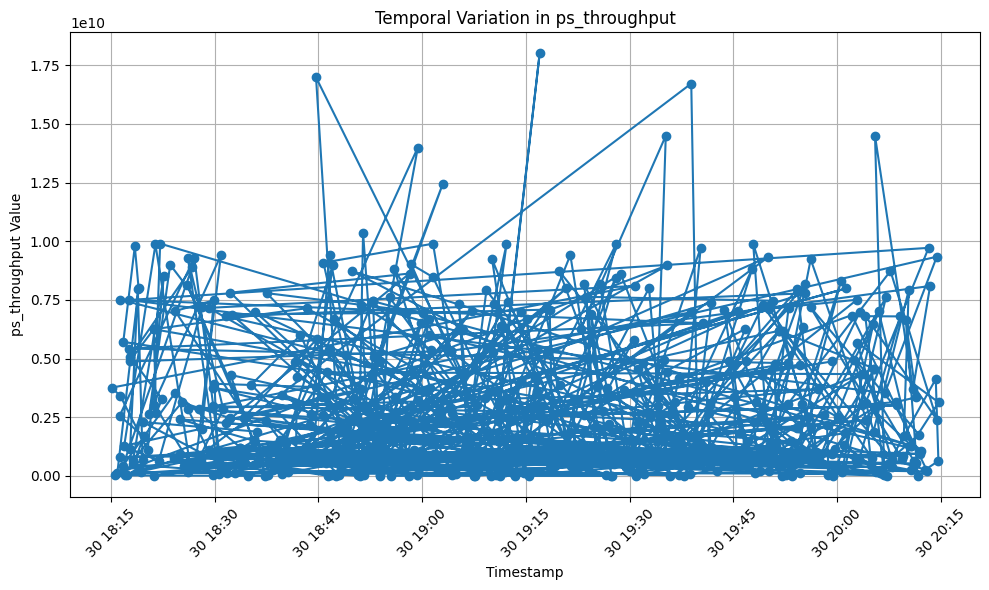

In [95]:
import time
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

es = Elasticsearch([{'host': 'atlas-kibana.mwt2.org', 'port': 9200, 'scheme': 'https'}],
                    request_timeout=240, basic_auth=(user, passwd), max_retries=10)

# INDICES = ['ps_packetloss', 'ps_owd', 'ps_throughput', 'ps_trace']
dateFrom, dateTo, idx = ['2023-01-30 18:15', '2023-01-30 20:15', 'ps_throughput']
start, end = GetTimeRanges(dateFrom, dateTo, 1)
data = queryIndex(es, start, end, idx)
df = pd.DataFrame(data).T

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Plotting the temporal variation
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['throughput'], marker='o')
plt.title('Temporal Variation in ps_throughput')
plt.xlabel('Timestamp')
plt.ylabel('ps_throughput Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


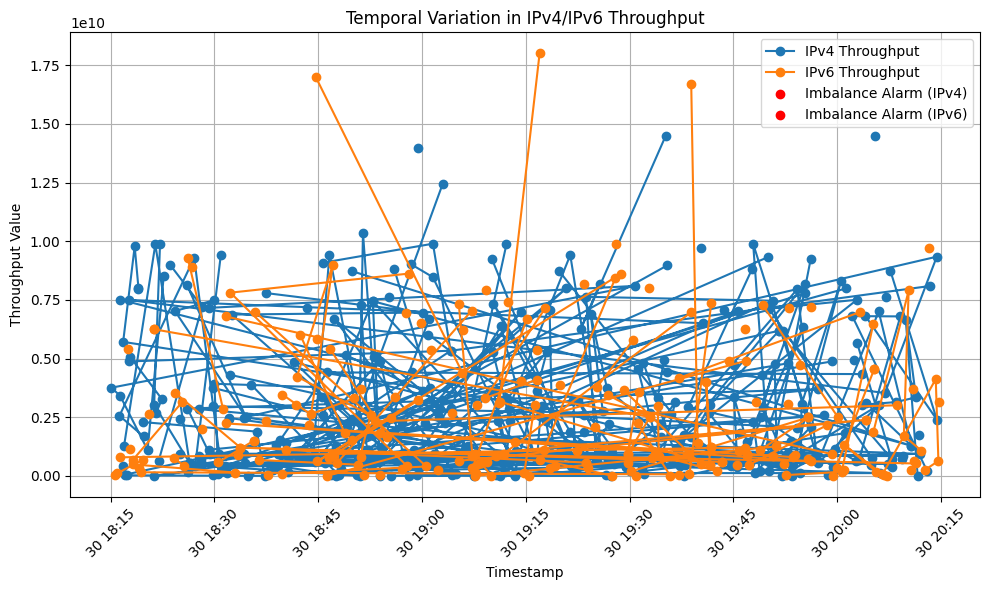

In [103]:
import time
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

es = Elasticsearch([{'host': 'atlas-kibana.mwt2.org', 'port': 9200, 'scheme': 'https'}],
                    request_timeout=240, basic_auth=(user, passwd), max_retries=10)

# INDICES = ['ps_packetloss', 'ps_owd', 'ps_throughput', 'ps_trace']
dateFrom, dateTo, idx = ['2023-01-30 18:15', '2023-01-30 20:15', 'ps_throughput']
start, end = GetTimeRanges(dateFrom, dateTo, 1)
data = queryIndex(es, start, end, idx)
df = pd.DataFrame(data).T

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Calculate IPv4 and IPv6 throughput
df['ipv4_throughput'] = df['throughput'].where(df['ipv6'] == False)
df['ipv6_throughput'] = df['throughput'].where(df['ipv6'] == True)

# Calculate ratio of IPv4 to IPv6 throughput
df['ipv4_ipv6_ratio'] = df['ipv4_throughput'] / df['ipv6_throughput']

# Set threshold for imbalance alarm
threshold = 2.0  # You can adjust this threshold value

# Detect IPv4/IPv6 throughput imbalance
imbalanced_data = df[df['ipv4_ipv6_ratio'] > threshold]

# Plotting the temporal variation
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['ipv4_throughput'], marker='o', label='IPv4 Throughput')
plt.plot(df['timestamp'], df['ipv6_throughput'], marker='o', label='IPv6 Throughput')
plt.scatter(imbalanced_data['timestamp'], imbalanced_data['ipv4_throughput'], color='red', label='Imbalance Alarm (IPv4)')
plt.scatter(imbalanced_data['timestamp'], imbalanced_data['ipv6_throughput'], color='red', label='Imbalance Alarm (IPv6)')
plt.title('Temporal Variation in IPv4/IPv6 Throughput')
plt.xlabel('Timestamp')
plt.ylabel('Throughput Value')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


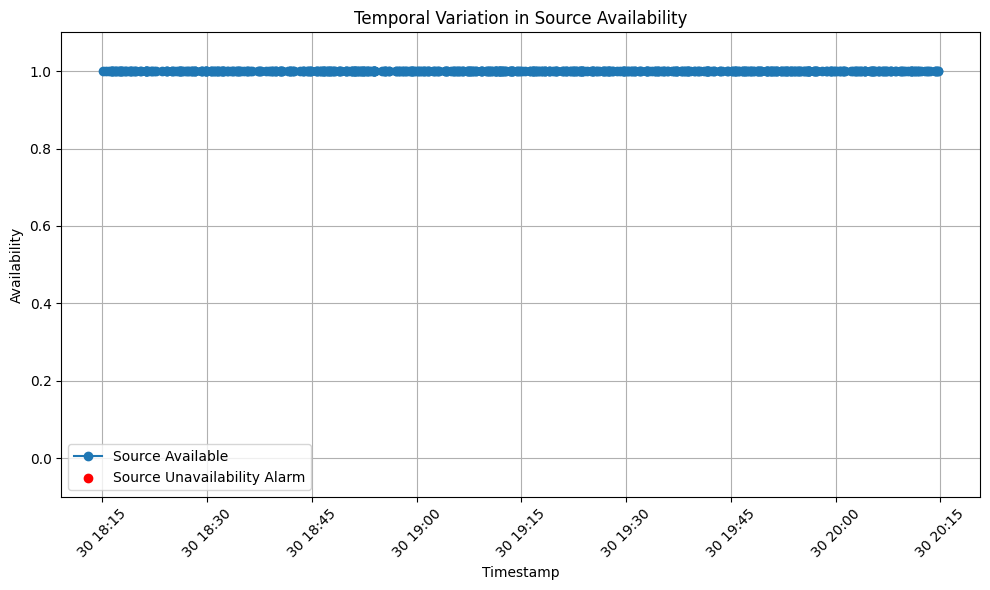

Source Unavailability Percentage: 0.00%


In [108]:
import time
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

es = Elasticsearch([{'host': 'atlas-kibana.mwt2.org', 'port': 9200, 'scheme': 'https'}],
                    request_timeout=240, basic_auth=(user, passwd), max_retries=10)

# INDICES = ['ps_packetloss', 'ps_owd', 'ps_throughput', 'ps_trace']
dateFrom, dateTo, idx = ['2023-01-30 18:15', '2023-01-30 20:15', 'ps_throughput']
start, end = GetTimeRanges(dateFrom, dateTo, 1)
data = queryIndex(es, start, end, idx)
df = pd.DataFrame(data).T

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Calculate source availability
df['source_unavailable'] = df['src_host'].isnull()

# Set threshold for source unavailability alarm
threshold_percentage = 10.0  # Adjust this threshold value

# Detect source unavailability
unavailable_data = df[df['source_unavailable']]

# Calculate the percentage of time the source was unavailable
unavailability_percentage = (len(unavailable_data) / len(df)) * 100

# Plotting the temporal variation
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], ~df['source_unavailable'], marker='o', label='Source Available')
plt.scatter(unavailable_data['timestamp'], ~unavailable_data['source_unavailable'], color='red', label='Source Unavailability Alarm')
plt.title('Temporal Variation in Source Availability')
plt.xlabel('Timestamp')
plt.ylabel('Availability')
plt.xticks(rotation=45)
plt.ylim([-0.1, 1.1])
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

# Print unavailability percentage
print(f"Source Unavailability Percentage: {unavailability_percentage:.2f}%")
